# Intro

It's the last time we meet in class for exercises! And to celebrate this mile-stone, we've put together an amazing set of exercises.

* We'll start with looking at communities and their words in two exercise
  - Part A1: First we finish up the work on TF-IDF from last week.
  - Part A2: Second, we play around with sentiment analysis - trying to see if we can find differences between the communities.
* In the latter half of the exercises, Part B, we'll try something completely new. As it turns out, **The two Comic Book Universes have been infected with COVID-19**. There's a lot of cool stuff you can do to understand disease spreading on networks, but we're also mindful of your time. Therefore, many of the exercises in part B are optional

![im](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/wonder_woman_mask.png "mask")


## The informal intro

First the pep-talk. A bit about the exercises today and some general silliness.

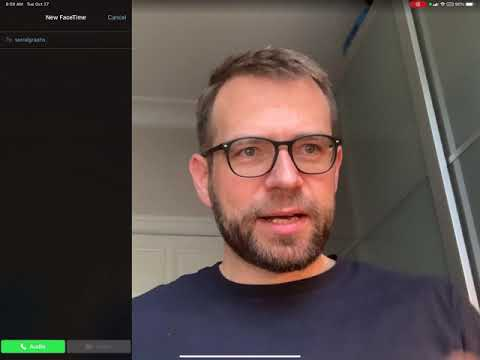

In [1]:
from IPython.display import YouTubeVideo, HTML, display
YouTubeVideo("mbQHqFnqAqw",width=800, height=450)

Next (and I've separated this part out for your convenience) I talk a bit about the final projects. Among other things, I 

* Explain what the whole thing is about
* Why the project has two parts, and how that's brilliant.
* What you'll need to do to succeed in the written part of the project.
* The time-table for the last weeks of the class.

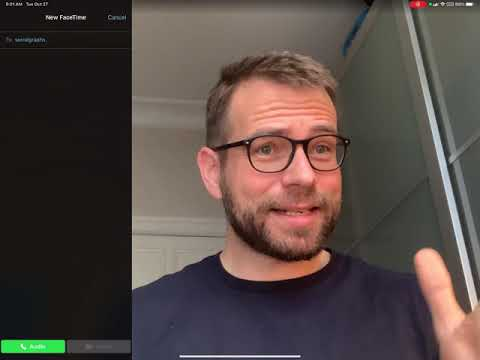

In [2]:
YouTubeVideo("JMVCVY8LB54",width=800, height=450)

# Part A1: Communities TF-IDF word-clouds


We continue where we left off last time, so the aim of this part is to create community wordclouds based on TF-IDF. Once again, it's still OK to only work with a single universe (e.g. Marvel or DC).

The aim is to understand which words are important for each community. And now that you're TF-IDF experts, we're going to use that strategy. 

Let's start by creating $N_C$ documents, where $N_C$ is the number of communities you have found in exercise 3. **We will work with the 10 largest communities.**

In [60]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import colors
import random
import math
import collections

import community

import glob
import os
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

import string as StringLibrary

sns.set()

In [7]:
df_marvel = pd.read_csv('marvel_characters.csv',sep ='|')
df_marvel = df_marvel.iloc[:,[1,2]]

In [8]:
df_dc = pd.read_csv('dc_characters.csv',sep ='|')
df_dc = df_dc.iloc[:,[1,2]]
df_dc = df_dc.rename(columns = {'WikiLink;':'WikiLink'}, inplace = False)
df_dc['WikiLink'] = df_dc['WikiLink'].str.strip(';')

In [9]:
import networkx as nx

# Create the Comics network as a directed graph
comics_graph = nx.DiGraph()

In [10]:
# Add nodes and with data (character name & universe)

# For MARVEL
for character_name in df_marvel['CharacterName']:
    comics_graph.add_node(character_name)
     
    # define universe
    comics_graph.nodes[character_name]['universe'] = 'marvel'
    
# For DC
for character_name in df_dc['CharacterName']:
    comics_graph.add_node(character_name)

    # define universe
    comics_graph.nodes[character_name]['universe'] = 'dc'

In [11]:
# Funtion for adding the links/references between the characters to the graph
def link_input(df, path_name, graph):
    for character_name_in in df['CharacterName']:

        # Load the page of the superhero, in a try-except clause for error catching
        try:
            with open(path_name + character_name_in + '.txt', 'r', encoding = 'utf8') as wiki_page:
                page = wiki_page.read()

            # Get all the reference links on the page (using regex)
            links = re.findall('\[{2}((?!.+?:)([^\]\[]+)\|([^\]\[]+)|([^\|]+?))\]{2}', page)
            reference_links = [(tuple(int(x) if x.isdigit() else x for x in _ if x)) for _ in links]

            for i in range(len(reference_links)):

                for character_name_out in df['CharacterName']:
                    if character_name_out == reference_links[i][0]:
                        # Add edge 1 by 1
                        graph.add_edge(character_name_in, reference_links[i][0])
        except:
            pass
        
    return graph

In [12]:
comics_graph = link_input(df = df_dc, path_name = './data/dc/', graph = comics_graph)
comics_graph = link_input(df = df_marvel, path_name = './data/marvel/', graph = comics_graph)

In [13]:
# Remove the isolated nodes from the graph
comics_graph.remove_nodes_from(list(nx.isolates(comics_graph)))

In [14]:
for component in list(nx.connected_components(comics_graph.to_undirected())):
    if (len(component) < 5):
        for node in component:
            comics_graph.remove_node(node)

In [15]:
# Create the undirected version of the Comics universe graph
comics_graph = comics_graph.to_undirected()

In [16]:
# Make list of DC-character nodes
dc_nodes = [character_name for character_name, attr in comics_graph.nodes(data = True) if attr['universe'] == 'dc']
dc_graph = comics_graph.subgraph(dc_nodes)

# Create the undirected version of the DC universe graph
dc_graph = dc_graph.to_undirected()

In [17]:
import community

In [19]:
partition_dc = community.best_partition(dc_graph)

In [20]:
print("The Louvain algorithm has found", len(set(partition_dc.values())), "communities for our DC network.")

The Louvain algorithm has found 14 communities for our DC network.


_Exercise 1_:

> * Now that we have the communities, let's start by calculating a the TF list for each community (use whichever version of TF you like). Find the top 5 terms within each universe. 

In [21]:
# Let us split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_dc.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_dc.items() if comm == community_nr]

In [22]:
# Sort the community dictionary according to the size of each community 
rank = sorted(dict_communities, key=lambda k:len(dict_communities[k]), reverse = True)

# Pick the largest 10 communites
communities = {k:v for k, v in dict_communities.items() if k in rank[:10]}

Now, we will concatenate all the documents inside a community into one, for computational speed:

In [23]:
# Function for retriving all the documents and combine them into a single one for each community
def community_document(community=communities, id_path='data/dc'):
    # Create a dictionary for storing text of each community
    community_document_text = {}
    
    # Within each community
    for comm, _ in community.items():
        try:
            document_text = []
            for name in community.get(comm):
                # Generate the file path from the name of community
                path = os.path.join(os.getcwd(), id_path, (name+'.txt'))
                # Load file
                with open(path, 'r', encoding='utf-8') as f:
                    file = f.read()
                    document_text.append(file)
                
        except:
            pass
                
        community_document_text[comm] = ' '.join(document_text)
                    
    return community_document_text

In [24]:
# Dictionary with structure as {community : text}
community_document_text_dc = community_document()

Next, it is necessary to tokenize the original long texts into lists of words/tokens:

In [25]:
# Function for tokenizing the text into a list of words
def tokenize_text(text):
    # Replace all the HTML tags with ''
    text = re.sub(r'<\w+>', '', text)
    # Replace all the non-alphanumeric characters and numbers with space
    text = re.sub(r'[\W\_\d]', ' ', text)

    # Tokenize pages into individual strings
    words = text.split(' ')
    
    # Remove all the punctuations and stopwords, set words to lower-case and lemmatize the words
    wnl = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = [wnl.lemmatize(word.lower()) for word in words 
             if word not in StringLibrary.punctuation
             if word not in stop_words]
    
    return words

The term frequency will be computed using different weighting methods:

In [26]:
# Function for computing term-frequency
def community_term_frequency(community_document_text, tf_method='term_frequency'):
    # Creating a dictionary for storing term counts of each community
    community_term_count = {} 
    # Creating a dictionary for storing term frequency of each community
    community_term_frequency = {}
    
    # Get text from each community
    for comm, text in community_document_text.items():
        community_term_frequency[comm] = {}
        community_term_count[comm] = {}
        
        # Tokenize the text into a list of words
        words = tokenize_text(text)
        
        # Count the occurrence of each word
        for word in words:
            if word not in community_term_count[comm].keys():
                community_term_count[comm][word] = 1
            else:
                community_term_count[comm][word] += 1
    
    
        # Compute different types of term frequency
        if tf_method == 'raw_count':
            return community_term_count

        elif tf_method == 'term_frequency':
            community_term_frequency[comm] = {k:v/len(community_document_text[comm]) for k,v in community_term_count[comm].items()}

        elif tf_method == 'log':
            community_term_frequency[comm] = {k:math.log(1 + v) for k,v in community_term_count[comm].items()}

        elif tf_method == 'double_normalization':
            community_term_frequency[comm] = {k:(0.5 + 0.5*v/max(community_term_count[comm].values())) 
                                              for k,v in community_term_count[comm].items()}

    return community_term_frequency

In [30]:
# Dictionary with structure as {community : {word : term frequency}} 
community_term_frequency_dc = community_term_frequency(community_document_text = community_document_text_dc)

Numerous ways of calculating the weights of terms can be applied, as shown in the function above:

* __Raw count__: This method simply counts the occurrence of each word.

* __Term frequency__: This method takes the total number of words of each document into account. For instance, if the counts of a word is high, but not high comparing to the total amount of words shown in a text, then this word is likely to not be too important.

* __Log__: This method uses the logarithm scale, which manages to shrink the difference of weights between highly frequent words and less frequent ones.

* __Double normalization__: This method aims to mitigate the case that we observe higher term frequencies in longer documents, merely because longer documents tend to repeat the same words over and over again.

<font color='blue'> We chose to use ___term frequency___ ( adjusted for document length) for our scenario, since it modifies the original frequency (i.e. raw counts) by considering the length of texts, because the wiki content of each character varies significantly. Therefore, in order to avoid words to have a higher weight merely because they appear more in longer texts, adjustments were made according to document length. </font>

> * Next, calculate IDF for every word in every list (use whichever version of IDF you like). 
>   * Which base logarithm did you use? Is that important?

Here, after the Term Frequency is computed, we need to also compute the Inverse Document Frequency:

In [31]:
# Function for computing inverse-document-frequency
def community_inverse_document_frequency(community_document_text, community_term_frequency, idf_method='idf_smooth'):
    # Total number of documents
    N = len(community_document_text)
    
    community_inverse_document_frequency = {}
    
    # Create a nested dictionary {community : {word : 0}} for storing idf score in it afterwards
    for comm1 in community_term_frequency.keys():
        community_inverse_document_frequency[comm1] =  {k:0 for k in community_term_frequency[comm1].keys()}

        # For each word in one specific community, find how many times this word shown in other communities
        for word in community_term_frequency[comm1]:
            for comm2 in community_term_frequency.keys():
                if word in community_term_frequency[comm2].keys():
                    community_inverse_document_frequency[comm1][word] += 1
        
        # Compute different types of inverse document frequency 
        if idf_method == 'idf':
            community_inverse_document_frequency[comm1] = {k:math.log(N/v) for k, v in community_inverse_document_frequency[comm1].items()}
        elif idf_method == 'idf_smooth':
            community_inverse_document_frequency[comm1] = {k:(math.log(N/(1+v))+1) for k, v in community_inverse_document_frequency[comm1].items()}

    return community_inverse_document_frequency

In [34]:
# Dictionary with structure as {community : {word : inverse document frequency}} 
community_inverse_document_frequency_dc = community_inverse_document_frequency(community_document_text_dc, community_term_frequency_dc)

> * We're now ready to calculate TF-IDFs. Do that for each community. 
>   * List the 10 top words for each universe accourding to TF-IDF. Are these 10 words more descriptive of the universe than just the TF? Justify your answer.

Inverse document frequency (IDF) measures how common a word is across all the documents. 

Here we will implement two ways of calculating IDF scores: 

* __idf__: This method calculates the IDF score directly using the logarithm of the ratio $\frac{N}{n_t}$, where $N$ denotes the total number of documents and $n_t$ denotes the number of documents where the word occurs in. If the IDF score is low, it means that the word is not only common in one document, but it also tends to show up in several documents which suggests that this word might not be informative.

* __idf_smooth__: This method is a modified version of original IDF to solve the situation when the word occurs 0 times.

TF-IDF considers TF and IDF together by multiplying this two terms word-wise (TF shows how frequently a word occurs, while IDF could help to see whether the word is unique or not in corpus).

Let us compute the TF-IDF scores for our communities below:

In [35]:
# Function for computing TF-IDF score
def community_tf_idf(community_term_frequency, community_inverse_document_frequency):
    community_tf_idf = {}
    for comm in community_term_frequency:
        # Calculate TF-IDF score by multiplying TF score and IDF score
        community_tf_idf[comm] = {k:v*community_term_frequency[comm][k] for k,v in community_inverse_document_frequency[comm].items()}
    
    return community_tf_idf

In [36]:
# Dictionary with structure as {community : {word : TF-IDF score}} 

community_tf_idf_dc = community_tf_idf(community_term_frequency_dc, community_inverse_document_frequency_dc)

> * Create a wordcloud for each community. Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

Now we generate the wordcloud for each community:

In [37]:
# Function for converting the word dictionary into a string
def dict_to_string(word_dict, shrink=True):
    
    total_string = ''
    
    for word in word_dict:
        
        # If the counts of words are too large, we divide the original count by 10 for computing faster
        if shrink==True:
            repeat_nr = math.ceil(word_dict[word] / 100)
        
        else:
            repeat_nr = math.ceil(word_dict[word])
        
        # Create a string of one term (occuring, in a proportional manner, according to the TF-TR scores)
        string = ''.join([word+' ' for count in range(repeat_nr)])
        
        # Concatenate the current elements to the total string
        total_string += string
        
    return total_string

In [40]:
string = {}
wordclouds = []
for comm in community_tf_idf_dc.keys():
    
    string[comm] = dict_to_string(community_tf_idf_dc[comm], False)
    
    wordcloud = WordCloud(width = 1600, 
                          height = 800, 
                          collocations = False, 
                          background_color = 'white',
                          random_state = 29).generate(string[comm])
    wordclouds.append(wordcloud)

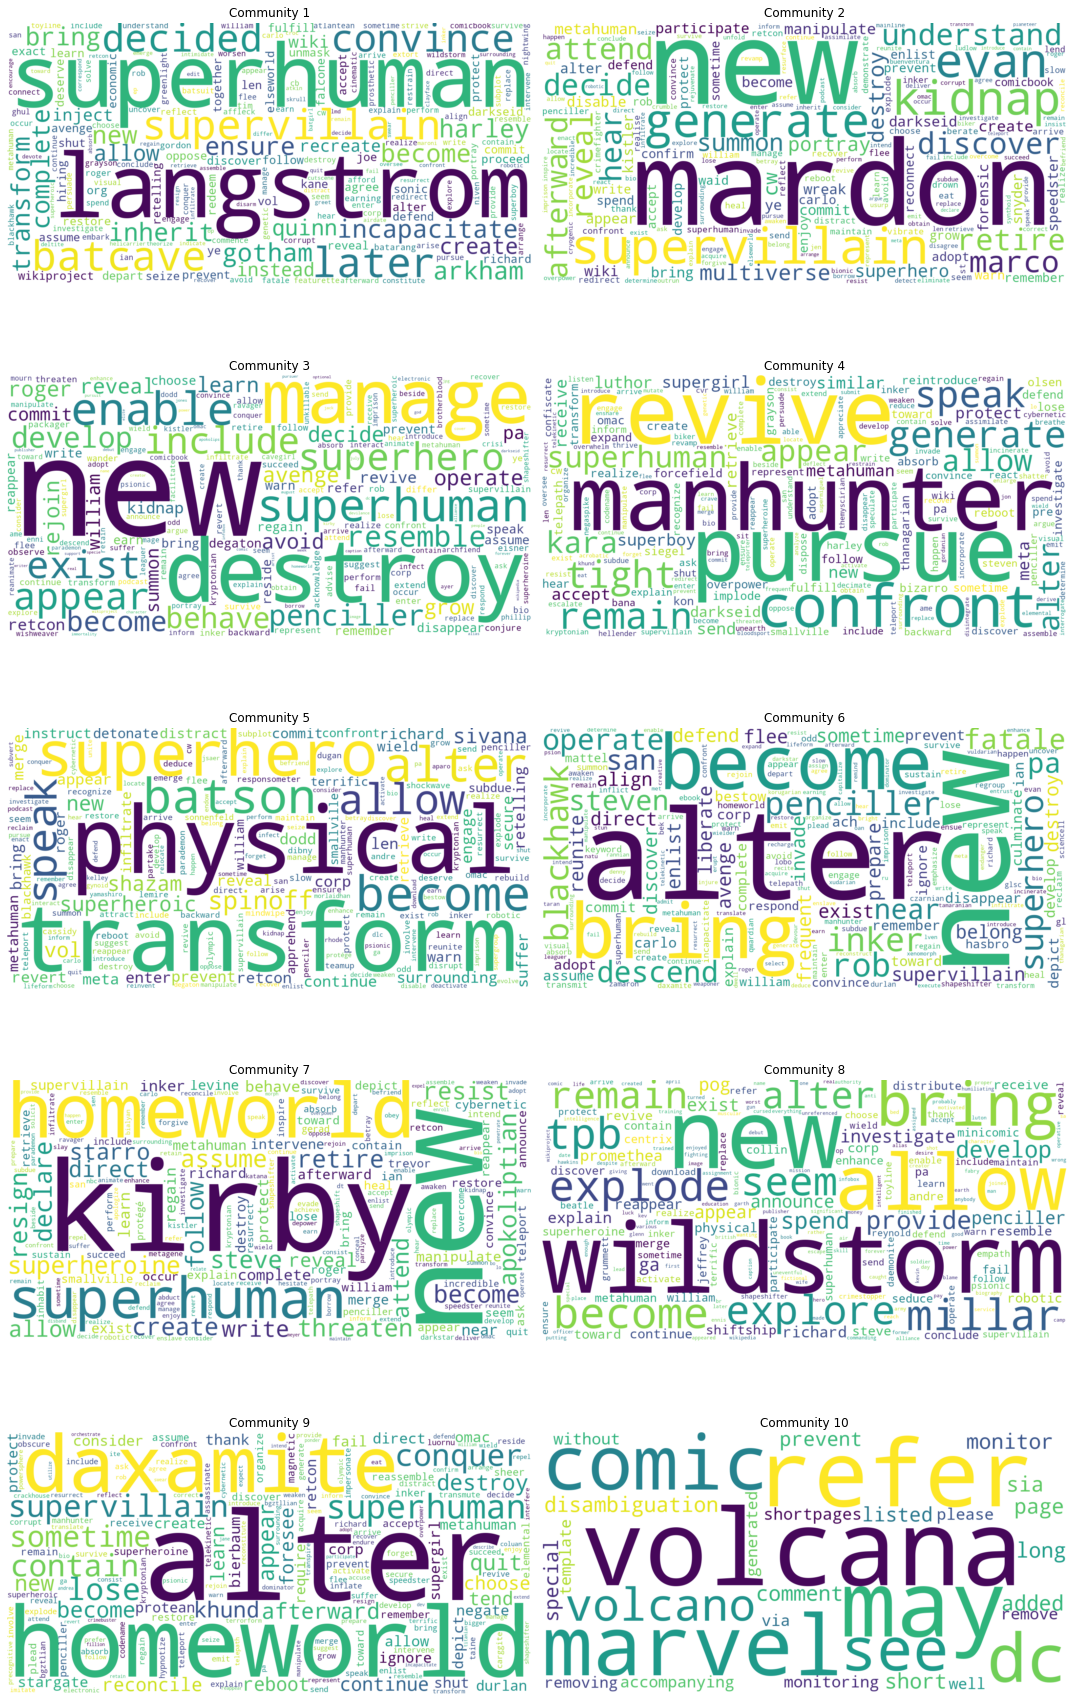

In [41]:
# Display the generated images
fig, axs = plt.subplots(5, 2, figsize = (15, 25))
axs[0, 0].imshow(wordclouds[0], interpolation='bilinear')
axs[0, 0].set_title('Community 1')
axs[0, 0].axis('off')

axs[0, 1].imshow(wordclouds[1], interpolation='bilinear')
axs[0, 1].set_title('Community 2')
axs[0, 1].axis('off')

axs[1, 0].imshow(wordclouds[2], interpolation='bilinear')
axs[1, 0].set_title('Community 3')
axs[1, 0].axis('off')

axs[1, 1].imshow(wordclouds[3], interpolation='bilinear')
axs[1, 1].set_title('Community 4')
axs[1, 1].axis('off')

axs[2, 0].imshow(wordclouds[4], interpolation='bilinear')
axs[2, 0].set_title('Community 5')
axs[2, 0].axis('off')

axs[2, 1].imshow(wordclouds[5], interpolation='bilinear')
axs[2, 1].set_title('Community 6')
axs[2, 1].axis('off')

axs[3, 0].imshow(wordclouds[6], interpolation='bilinear')
axs[3, 0].set_title('Community 7')
axs[3, 0].axis('off')

axs[3, 1].imshow(wordclouds[7], interpolation='bilinear')
axs[3, 1].set_title('Community 8')
axs[3, 1].axis('off')

axs[4, 0].imshow(wordclouds[8], interpolation='bilinear')
axs[4, 0].set_title('Community 9')
axs[4, 0].axis('off')

axs[4, 1].imshow(wordclouds[9], interpolation='bilinear')
axs[4, 1].set_title('Community 10')
axs[4, 1].axis('off')

plt.tight_layout(pad = 1)

<font color='blue'> These results are very relevant for the DC communities that we have identified, as the wordclouds describe what is unique about the pages of each community. </font>

<font color='blue'> For example, we can most likely say that Community 2 is where Superman and Lex Luthor reside, since one of the most important discussed topics is _kryptonite_. Each of these wordclouds are somehow a mirror of the key events and people which are talked about inside that community, and by looking at each and every one of them, we can see that they are quite different. </font>

<font color='blue'> Lastly, it can be clearly seen that topics such as 'superhuman', 'metahuman' and 'supervillain' are important discussions across most communities, even if they are written using slightly different words for each community. </font>

# Part A2 - Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.



> **Video Lecture**: Uncle Sune talks about sentiment and his own youthful adventures.



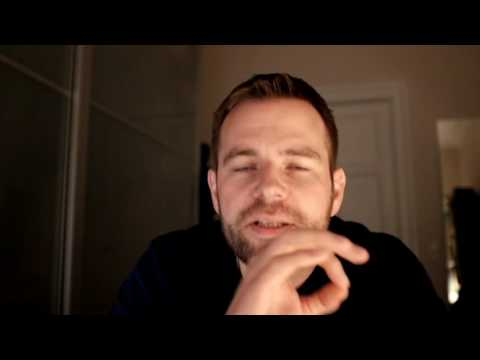

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("JuYcaYYlfrI",width=800, height=450)

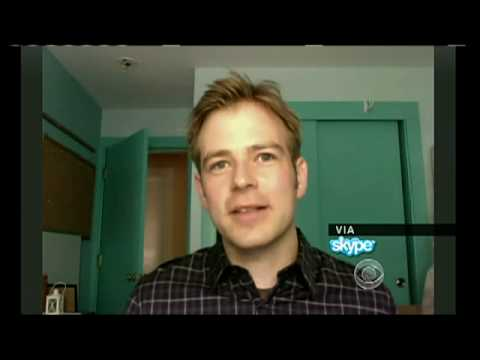

In [4]:
# There's also this one from 2010
YouTubeVideo("hY0UCD5UiiY",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


_Exercise_ 2: Sentiment within the communities data. It's still OK to work with data from a single universe, and - unlike above - we work all communities.
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.

In this exercise the LabMT wordlist will be used as a reference dictionary to look up word average happiness score for the words of the pages/nodes from the DC universe.

**_A brief description of the LabMT wordlist:_**

The raw texts are composed 4 disparate text sources: Twitter, Google Books, music lyrics and the New York times. Wordlist extracted from the text sources are ordered by decreasing frequency of occurrence. Top 5000 words from each of the text sources are merged to form a set of 10222 unique words.

Amazon's Mechanical Turk evaluations were used to define the happiness level of words extracted from the text sources, which rates the words on a 9 point scale.

In [42]:
## take a look at the LabMt wordlist
LabMT = pd.read_csv('LabMT.txt', sep="\t", skiprows = 2)
LabMT

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10217,murder,10218,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219,1.48,0.9089,--,--,3192,--
10219,rape,10220,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221,1.30,0.8391,2124,4707,3319,2107


> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

**The scores or happiness average scores are calculated using the formula**

$$h_{avg}(T)=\frac{\sum_{i=1}^N h_{avg}(w_i)f_i}{\sum_{i=1}^Nf_i} = \sum_{i=1}^Nh_{avg}(w_i)p_i$$

**From which $h_{avg}(w_i)$ is the average word happiness score given in the LabMT table and p_i is the normalized frequency of the word of interest.**

In [43]:
# create a word happiness score look up dictionary using LabMT

labmt = pd.Series(LabMT.happiness_average.values,index = LabMT.word.values).to_dict()

In [44]:
def sentiment(tokens):
    ## find word hapiness score by looking up the labmt dictionary 
    hw = {k:v for k,v in labmt.items() if k in tokens}
    
    ## sort hw by key values
    HW = dict(sorted(hw.items()))
    
    ## create frequency distribution of the token 
    text = nltk.Text(tokens)
    text_freq = nltk.FreqDist(text)
    
    ## noramlize term frequency 
    sum_f = sum(text_freq.values())
    pi = {k:v/sum_f for k,v in text_freq.items()}
    
    ## sort pi by key values 
    PI = dict(sorted(pi.items()))
    
    ## calculate sentiment 
    sen = sum(HW[k]*PI[k] for k in HW)
    
    return sen 

> * Iterate over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property. 

In [46]:
v = list(dc_graph.nodes())

corpus_dc = {}
for char in v:
    filename = str(char)+'.txt'
    filepath = os.path.join(os.getcwd(), "data/dc", filename)
    try:
        with open(filepath,encoding = 'utf-8') as f_input:
            corpus_dc[char] = (f_input.read())
    except:
        print('failed for', char)

failed for Dorling Kindersley


In [47]:
len(corpus_dc.keys())

1277

First we will tokenize all the pages for later analysis. 

In [48]:
tokens = {}
for k,v in corpus_dc.items():
    print
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus_dc[k]) if w.isalpha()]))

In [49]:
print('There are in total', len(tokens.keys()), 'nodes/pages.')

There are in total 1277 nodes/pages.


In [50]:
sentiment_list = {}

for k,v in tokens.items():
    sentiment_list[k] = sentiment(tokens[k])

> * Remember histograms? Create a histogram of all character's associated page-sentiments.

In [53]:
sentiments = sorted([v for k,v in sentiment_list.items()],reverse = True)
sentimentscount = collections.Counter(sentiments)
sent, count = zip(*sentimentscount.items())

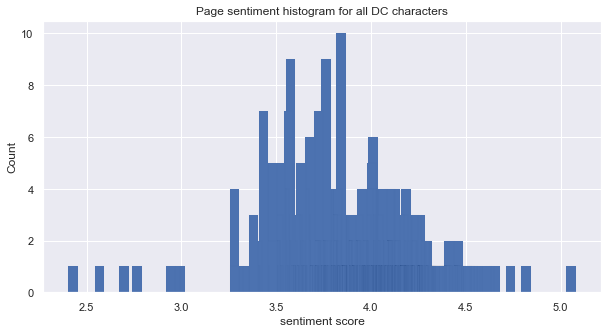

In [56]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = [10, 5])
    plt.bar(sent, count, width=0.05, edgecolor = 'black',linewidth=0.01)
    plt.xlabel('sentiment score')
    plt.ylabel('Count')
    plt.title('Page sentiment histogram for all DC characters')
    plt.show()

<font color='blue'> As we can see from the histograms, majority of sentiments of character pages lies slightly below the neutral level of happiness score, with few above and few below. It can be interpreted that as the content of the two comics involving frequent actions, wars, conflicts within their storylines, word choices of these comics would generally be rated as less "happy". Moreover, it is to note that none of the page sentiments had scores above 5.0 as the text sources are from wikipages that are known to be written in as neutral tones as possible. 

> * What are the 10 characters with happiest and saddest pages?

In [57]:
# Sort the character-sentiment list according to their sentiment score
char_sentiment = sorted(sentiment_list.items(),key=lambda x: x[1],reverse = True)

print('The 10 characters with the happiest pages are: \n')

for i in range(10):
    print('#' + str(i+1) + ":", char_sentiment[i])

The 10 characters with the happiest pages are: 

#1: ('Billy the Kid', 5.054545454545455)
#2: ('Doctor Trap', 4.8184615384615395)
#3: ('Weather Witch', 4.735555555555556)
#4: ('Binky', 4.65337278106509)
#5: ('Buzz', 4.6256739811912215)
#6: ('Rose Psychic', 4.608333333333333)
#7: ('White Magician', 4.56)
#8: ('Killer Wasp', 4.55)
#9: ('Lyla Lerrol', 4.534741144414167)
#10: ('Blue Tracer', 4.532)


In [58]:
print('The 10 characters with the saddest pages are: \n')

for i in range(len(char_sentiment) - 10, len(char_sentiment)):
    print('#' + str(len(char_sentiment) - i) + ":", char_sentiment[i])

The 10 characters with the saddest pages are: 

#10: ('Beast', 3.281240341602284)
#9: ('Bright, Jess', 3.281240341602284)
#8: ('Mind-Grabber Kid', 3.2794509803921543)
#7: ('Davis Bloome', 2.9955555555555553)
#6: ('Prince Evillo', 2.9680000000000004)
#5: ('Nebiros', 2.942156862745098)
#4: ('Jacob Krigstein', 2.767094801223242)
#3: ('Mnemoth', 2.6966666666666668)
#2: ('Lion-Mane', 2.568)
#1: ('Tess Mercer', 2.428888888888889)


<font color='blue'> The happiest and saddest pages are mostly quite short which means they contain less information and few positive words and negative words will have greater influence on their sentiment scores. For example, the description of Lion-Mane is one sentence but already contains 'fought', 'expelled' and 'possessed'. On the other hand, Doctor Trap received high score because another reason which is that a lot of key words in its description was not contained in the LabMT wordlist, leaving few rather neutral words and thus higher sentiment score. 

> * Now we average the average sentiment of the nodes in each community to find a *community level sentiment*. 
> * Name each community by its three most connected characters. 

In [61]:
avg_sent = {}
for com in dict_communities.keys():
    avg_sent[com] = np.mean([v for k,v in sentiment_list.items() if k in dict_communities[com]])

In [62]:
# Rename the avg_sent list 
for com in dict_communities.keys():
    new_name = list(zip(*sorted(dict(dc_graph.degree(dict_communities[com])).items(),key=lambda x: x[1],reverse = True)[:3]))[0]
    avg_sent[new_name] = avg_sent.pop(com)
print('The community sentiment lists named after their three most connected characters are \n')
avg_sent

The community sentiment lists named after their three most connected characters are 



{('Batman', 'Deathstroke', 'Black Canary'): 3.9214115470468305,
 ('Gorilla Grodd', 'Vandal Savage', 'Wally West'): 3.9929075485757677,
 ('Dorling Kindersley', 'Power Girl', 'Animal Man'): 3.998470629434054,
 ('Superman', 'Wonder Woman', 'Lex Luthor'): 3.9310786157589086,
 ('Black Adam', 'Booster Gold', 'Maxwell Lord'): 3.9392117516789513,
 ('Green Lantern', 'Hal Jordan', 'Sinestro'): 3.8305667350332526,
 ('Donna Troy', 'Miss Martian', 'Steve Trevor'): 3.9871350850124165,
 ('Owlwoman', "Y'onia, Fain", 'Midnighter'): 4.031330446332282,
 ('Darkseid', 'Superboy-Prime', 'Brainiac 5'): 3.9621447974274178,
 ('Volcana',): 4.391219512195123,
 ('8-Ball',): 4.276428571428572,
 ('Blizzard',): 3.9584079601990054,
 ('Bliss',): 3.4785714285714286,
 ('Blackwing',): 4.039033078880408}

>   - What are the three happiest communities?

In [63]:
community_sentiment = sorted(avg_sent.items(),key=lambda x: x[1],reverse = True)

In [64]:
print('The 3 happiest communities are: \n')

for i in range(3):
    print('#' + str(i+1) + ":", community_sentiment[i][0], ':', community_sentiment[i][1])

The 3 happiest communities are: 

#1: ('Volcana',) : 4.391219512195123
#2: ('8-Ball',) : 4.276428571428572
#3: ('Blackwing',) : 4.039033078880408


>   - what are the three saddest communities?

In [65]:
print('The 3 saddest communities are: \n')

for i in range(len(community_sentiment) - 3, len(community_sentiment)):
    print('#' + str(len(community_sentiment) - i) + ":", community_sentiment[i][0], ':', community_sentiment[i][1])

The 3 saddest communities are: 

#3: ('Batman', 'Deathstroke', 'Black Canary') : 3.9214115470468305
#2: ('Green Lantern', 'Hal Jordan', 'Sinestro') : 3.8305667350332526
#1: ('Bliss',) : 3.4785714285714286


>   - Do these results confirm what you can learn about each community by skimming the wikipedia pages?

<font color='blue'> The results overall makes sense. For example, "8-Ball" only has a 1-line description and already contains twice the word 'bullets' which gives it a low sentiment score, blizzard itself is a "unhappy" word. 'bliss' has a relatively darker description which also makes sense. Moreover, for the happiest communitites words in the Wikipedia pages tends to be less aggresive or extreme. However, it is important to point out that due to the nature of wikipedia pages being quite neutral, there are very limited difference in sentiment scores of the communities. Another limitation is shown by the words in the descriptions of the comics pages are not very general use words, thus does not appear in the LabMT list. 

Calculating sentiment takes a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

# Part B1

### Epidemics intro

In this exercise we will now look at a network based approach to epidemic phenomena (which in the light of the world today seem pretty relevant). This will not only give some great visualizations, where we can see how the spread envolves over time, but also allow us to understand and predict the impact of for example communities, superspreaders and vaccines.  

We will use the SIR-model (as this is what we very much hope describes Covid-19) - have a look at chapter 10 in the [Network Science book](http://networksciencebook.com/) and/or at the [wikipage](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) if you want to read about the SIR-model (as well as other types of compartmental models in epidemiology): 


> *Reading*. For Chapter 10: Epidemics of the Network Science book, the part we will read is about epidemiology without networks. So you get a bit of background.
> 
> * Read 10.1
> * Read 10.2. (Ok to just skim the derivations of SI & SIS model solution)

Instead of the book 10.3 (Network Epidemics) and 10.4 (Contact Networks), 10.5 (Beyond the Degree Distribution), 10.6 (Immunization), 10.7 (Epidemic Prediction), we will do some exercises (see below), which will give you a sense of thinking about epidemics on networks. 

But - as you can tell from the titles, you should check out those latter parts of the chapter if you’re interested in this stuff. So much is relevant in this COVID-19 times. It gives you a sense of why I’m part of the Danish COVID-19 modeling task force. If we had more time, I would have loved to dive into this. 


*Exercise*: Check your reading
> * What is homogeneous mixing. Is that a good assumption? 
> * What is the endemic state in the SI model?
> * What is the definition basic reproductive number R0?
> * Why is the SIR model the right model for modeling COVID-19? Can you think of other diseases that it would work for.



### Step 0: Building a temporal model
- This is a temporal model, so you need to keep track of time. We start at time $t=0$.
- You must be able to keep track of the state of all nodes (e.g. using a dictionary or a node-property). Nodes should be able to take on the states $S$ (susceptible), $I$ (Infected), $R$ (Recovered).
- Once a node enters the $I$ state, they stay there for 10 time-steps, then enter the $R$ state. 
- Once a nodes enters the $R$ state, no further can happen to them.
- Initialize by assigning the state $S$ to all nodes at $t = 0$.
- Now we’re ready to simulate the epidemic
    - At $t = 0$. Pick a random node, infect that node.
    - For $t > 0$. 
      - For all infected nodes.
        - Get neighbors in $S$ state (ignore nodes in state $I$ or $R$).
        - Infect these susceptible nodes to infect with probability $p = 0.1$. (Use the random module)
        - Change their state to $I$. 
      - Update the state of any $I$ nodes that have been infectious for $10$ time-steps to $R$.
      - Save the graph and increment time $t$ by 1 
    
    
**Hints**: When you simulate an epidemic there's lot of temporal information to keep track of. We want you to write things from scratch, and that means that there's no right way to do things. In fact, *there are many ways you can different ways you can keep track of the information we mention above*. There is no right way. But below we have some suggestions for/thoughts on data-structures and strategies which might be helpful:*
    
*Idea 1) Save the full graph with attributes at each time-step*
 - You can save the graph (including all attributes) for each timestep in a list, remember to use `deepcopy` of the graph before appending it to the list
     - See [Python’s copy.deepcopy](https://docs.python.org/3/library/copy.html) to understand why that's important.
 - If you use this approach, you can keep track of how long each infectious node has been in the $I$ state, by introducing a new node attribute, which is 0 when the node is susceptible and increases by 1 for each time-step the node is infectious.

*Idea 2) Keep track of the information using a `dict` (this way you don't need to think about updating and saving the graphs at each time-step)*
- You need to store the state of each node and the infectious length - this can be done in one `dict`, but you can also just create two differents.
- Here, preassigning the length of the inputs will make things easier E.g. initialize your dictionary with lists that are 100 time steps long. For example, if your dictionary for node-states is called `states`, and you're looking at a node with ID `node-name` you could initialize it as 
    
> ``` states['node-name'] = [S, S, ..., S]``` # with 100 `S`'s

- And, after running the simulation, it might look something like

> ``` states['node-name'] = [S, S, ..., I, ..., I, R, ..., R]``` # where the list is still length 100
        

### Step 1: Visualizing infection on the network
First lets make a nice visualization of our network, where we can see how the epidemic spreads over time.

![GIF](https://github.com/SocialComplexityLab/socialgraphs2020/raw/master/files/Covid_Gif_0%2C25.gif)

*Exercise*
> * Run a single infection on your superhero network (Use only the giant conponent and convert to undirected) and create a movie showing how nodes turn from gray (S) to red (I) to  light gray (R) . 
>    - The movie can be created as a gif https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
> * In the SIR equations (see the book chapter 10, figure 10.6), everyone eventually gets infected. Explain in your own words why that happens.
> * In our visualization here, you can see that there are some highly visible degree 1 nodes on the periphery that *never get infected*. Explain in your own words what's going on with those guys. 
> * More generally, can we expect everyone to get infected when we simulate spreading on a real network?
>
> 
> *Hints:*
> - *Only calculate the positions for the nodes once*
> - *This might take a while on your network, so you it might be helpfull to try on a small random network first*

### Step 2: Introduce visualizations to summarize properties of the spread across many runs
We will now look at some other visualizations that might be more usefull when evaluating the spread of the epidemic, as well as the initiatives that can be taken (social distancing, vaccines etc.). We consider two different vizualizations here (we return to these in each of the subsequent exercises):

* Left: Susceptible, Infected and Recovered 
* Right: Infected + Recovered 

![Trend plots](https://github.com/SocialComplexityLab/socialgraphs2020/raw/master/files/Covid_Trend.png)

*Exercise*: Plotting epidemic properties

> - Do a single run with a random seed up to $t=100$
>    - Save the nodes that in each timestep are $S$, $I$ and $R$ respectively eg. in a `dict`.
> - Plot fraction of susceptible, infected, recovered nodes over time (left panel) and fraction of Infected + Recovered (right panel). Comment on your results.
> - Now repeat, so that you do many (say on the order of $\mathcal{N} =  25$) runs (each with an new random seed). Store the results of each run.
> - Plot the average fractions (both *Susceptible, Infected and Recovered* and *Infected + Recovered*) across your $\mathcal{N}$ runs. Average per time-steps. 

We call these *ensemble plots* (because we average over an ensemble of runs).  For an example of ensemble plots, see figure above. In the figure, we show the individual runs as light colors and the averages as solid lines.           

## Appendix: Optional exercises

When we created these execises we were full of ideas. So we came up with all kinds of cool things that one could play with. But there's already a lot to do today. And we're all out of classes. So we decided to make the execises available in case you wanted to try them out.

BUT. To make sure none of you are completely overwhelmed, we have made the rest of the exercises optional. 

In these exercises we investigate the effect on the different initiatives. Most of the exercises do not overlap, so if you don't plan on doing them all you can choose the ones that interest you the most.

### Optional 1: Vaccinations
One of the major topics in the discussion regarding Covid-19 is a potential vaccine. Let's look at how a (perfect) vaccine will affect the spread we saw in step 2.

*Exercise*
> - Vaccinate 10, 40, 70% of nodes
>    - *hint: Vaccination can in our model be obtained by putting nodes in the recovered state from the beginning*
> - Create ensemble plots of *Infected + recovered* for each of the vacination rates.
> - Explain your results in your own words.
> - Can you say anything about [herd immunity](https://en.wikipedia.org/wiki/Herd_immunity) from looking at these plots?

### Optional 2: Social distancing
Social distancing might be largest buzz word (even above vaccines) these days, but let's be honest, while we might socially distance our self from strangers, we still see our friends. Let's have a look at how this affect the spread of the epedemic. We can visualize this using the communities you found earlier; we imagine each community represents a different friend group.

*Exercise*

> - Use the network you created in step 1 (i.e. no vaccination)
> - Disconnect the communities
>    - identify which edges are **within** a community and which are **between** communities
>    - loop over all edges
>        - If edge is within a community: Keep it
>        - If edge is between a communities: Remove it with some probability (you can play around with different probabilities and see how this affect the spread).
> - Create ensemble plots for each scenario and compare the results by comparing *Infected + recovered* plots for the various amounts of social distancing.


### Optional 3: The effect of who is infected early
One might suspect that it has a large significance on the spread who (in the network) is infected first. Let's investigate this by controling who is infected in the first timestep.

*Exercise*
> - Plot averages of many runs (ensemble plots), seeding random individuals based on centrality (Choose your random seed among top 5% central characters).
> - Repeat, but this time chhose your random seed among the bottom 5% central characters.
> - Create ensemble plots for each scenario and compare the results by comparing *Infected + recovered* plots for top/bottom centrality individuals. To make it extra fancy, put in a plot of random seeding (just grab the results from above).

### Optional 4: Superspreaders 
To illustrate the concept of superspreaders we turn away from our super hero network and consider a watts-strogatz model instead. We will track the spread of the epedemic and then at some timestep introduce a superspreader (a node that is infected and has many connections) to see how the effect on the spread is.

*Exercise*
> - Create a watts-strogatz network with $n = 10000$, $k = 5$, $p = 0.1$.
> - Simulate the spread (as done in the previous exercises) setting a random node to Infected
>     - at time $t = 50$ introduce a new node that is infected and has many connections 
> - Repeat many times and create ensemble *Infected + Recovered* plots of the development of the spread as above.
> - Comment on the result
> - *Extra*: Play around with the timing of introducing the superspreader; does this have an effect on what happens?

### Optional 5: A non-perfect vaccine
One of the concerns regarding a vaccine, is that it is faulty. We will try to simulate what this could mean in the case of a random network under the following assumptions:
- People social distance a lot prior to the vaccine (i.e. the probability of nodes being connected is  low)
- Once the vaccine is introduced and everyone is vaccinated people stop socially distancing (e.i. the probability of nodes being connceted increases),
- The probability that a vaccinated person is immune is 30%.

*Exercise*

> - Create a random network 
>     - Use an Barabási–Albert network with $n = 10000$ and $m = 2$ (you're welcome to try different networks and settings too)
> - Start simulating the epidemic
>     - At time $t = 50$
>         - Vaccinate everyone, but only move nodes to Recovered with probability $0.3$.
>         - Add $1000$ edges at random
>     - Continue the simulation until $t = 100$.
> - Repeat many times and plot ensemble graphs for Infected + Recovered to understand what's going on. 
> - Comment on your results.

**Takehome message**: The point of these last two exercises is **not** to make accurate predictions, but to show you all that we can use simple mathematical models to sharpen our intuitions about things that might happen in the real world.

*Big thanks* to TA Benjamin for helping design the exercises for today.